Importing the Data from the Kaggle

In [39]:
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix, f1_score

print(tf.__version__)

2.15.0


In [3]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

40000


Data Manipulation of the accumlated data

In [4]:

# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


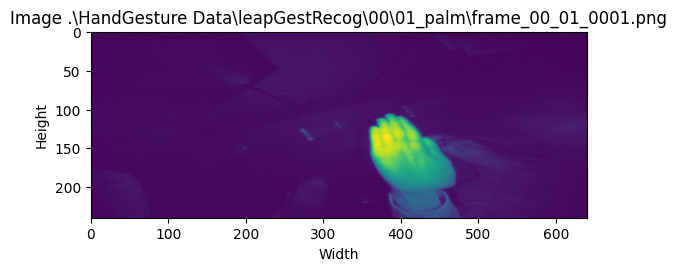

In [5]:
plot_image(imagepaths[0]) #to check the function with our first image

Now We have loaded the images and checked everything if everything is expected, 

(240, 640)


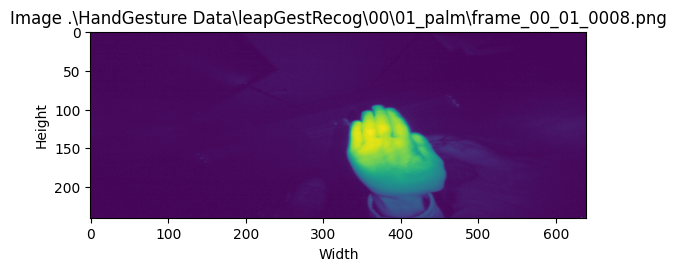

In [6]:
plot_image(imagepaths[7])

In [7]:
print(imagepaths[3])

.\HandGesture Data\leapGestRecog\00\01_palm\frame_00_01_0004.png


In [8]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)
  
  # Processing label in image path
  category = path.split("\\")[4]
  label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging
     

Images loaded:  40000
Labels loaded:  40000
1 .\HandGesture Data\leapGestRecog\00\01_palm\frame_00_01_0001.png


CReating the models

In [9]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)
     

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout

print(tf.__version__)

model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()


2.15.0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 116, 316, 32)      832       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 58, 158, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 156, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 28, 78, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 76, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 13, 38, 64)

Training a Model 

In [12]:
history=model.fit(X_train, y_train, epochs=3, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Epoch 1/3


438/438 - 427s - loss: 1.5209 - accuracy: 0.5119 - val_loss: 0.8360 - val_accuracy: 0.5282 - 427s/epoch - 974ms/step
Epoch 2/3
438/438 - 424s - loss: 0.7791 - accuracy: 0.5412 - val_loss: 0.7693 - val_accuracy: 0.5225 - 424s/epoch - 968ms/step
Epoch 3/3
438/438 - 417s - loss: 0.7318 - accuracy: 0.5401 - val_loss: 0.7461 - val_accuracy: 0.5166 - 417s/epoch - 951ms/step


In [13]:
model.save('handrecognition_model.h5')

c:\Users\MEHUL KINI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
model = tf.keras.models.load_model(r"C:\Users\MEHUL KINI\OneDrive\Desktop\Hand_Gesture_Recog\handrecognition_model.h5")
tf.saved_model.save(model, "tmp_model")
!python -m tf2onnx.convert --saved-model tmp_model --output "handrecognition_model.onnx"
!zip -r /content/tmp_model.zip /content/tmp_model

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets
2023-11-17 14:54:02.506030: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2023-11-17 14:54:14.183141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 14:54:14,185 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-11-17 14:54:14,

In [15]:
!python -m tf2onnx.convert --saved-model tmp_model --output "handrecognition_model.onnx"

2023-11-17 14:54:27.826263: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2023-11-17 14:54:36.076661: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 14:54:36,080 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-11-17 14:54:36,592 - INFO - Signatures found in model: [serving_def

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))
     
     

375/375 [==============================] - 40s 106ms/step - loss: 0.7461 - accuracy: 0.5166
Test accuracy: 51.66%


In [17]:
predictions = model.predict(X_test) # Make predictions towards the test set

375/375 [==============================] - 39s 100ms/step


In [18]:
np.argmax(predictions[0]), y_test[0] # If same, got it right

(6, 6)

In [20]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()


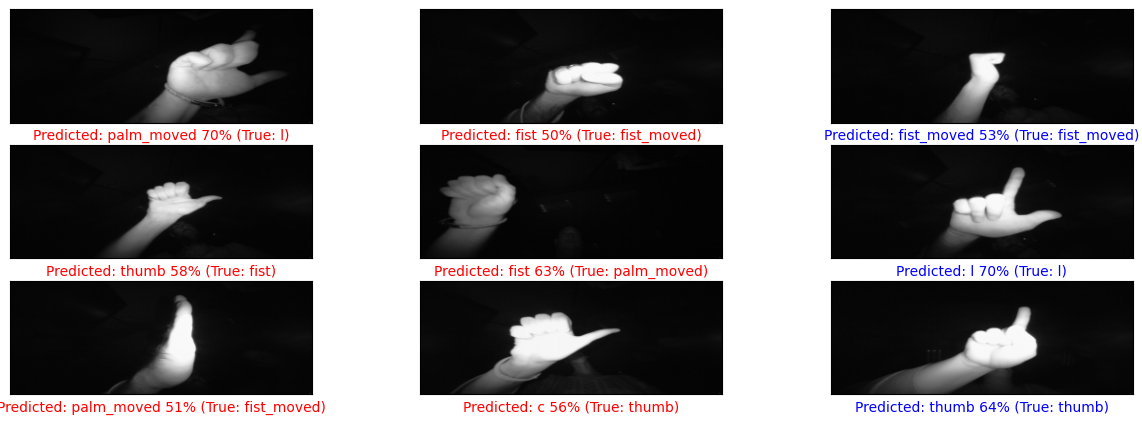

In [21]:
validate_9_images(predictions, y_test, X_test)

In [22]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number
     


In [40]:
# H = Horizontal
# V = Vertical

df_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

print(df_confusion_matrix)

                   Predicted Thumb Down  Predicted Palm (H)  Predicted L  \
Actual Thumb Down                   711                  51           27   
Actual Palm (H)                      71                 787           39   
Actual L                            127                 104          569   
Actual Fist (H)                     117                  55          104   
Actual Fist (V)                      45                 108           12   
Actual Thumbs up                     37                 109           77   
Actual Index                         34                  89           97   
Actual OK                            69                  58           81   
Actual Palm (V)                     109                 104           81   
Actual C                             61                  65           95   

                   Predicted Fist (H)  Predicted Fist (V)  \
Actual Thumb Down                  16                  55   
Actual Palm (H)                    62    

In [42]:
f1_scores = {}

# Calculate F1 score for each class
for i in range(df_confusion_matrix.shape[0]):
    true_positives = df_confusion_matrix.iloc[i, i]
    false_positives = df_confusion_matrix.iloc[i, :].sum() - true_positives
    false_negatives = df_confusion_matrix.iloc[:, i].sum() - true_positives
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)
    f1_scores[df_confusion_matrix.index[i]] = f1

print(f1_scores)

{'Actual Thumb Down': 0.5511627906976745, 'Actual Palm (H)': 0.5780389276533235, 'Actual L': 0.47318087318087315, 'Actual Fist (H)': 0.4581056466302368, 'Actual Fist (V)': 0.542306178669815, 'Actual Thumbs up': 0.5571984435797666, 'Actual Index': 0.4964059196617336, 'Actual OK': 0.5187772925764192, 'Actual Palm (V)': 0.4511910322279309, 'Actual C': 0.5116491548652352}
